# Predicting NDX from the closing prices of SPX and DJI

In [1]:
from google.colab import files
uploaded = files.upload()


Saving spx_daily_85.csv to spx_daily_85.csv
Saving ndx_daily_85.csv to ndx_daily_85.csv
Saving dji_daily_85.csv to dji_daily_85.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error

# All features

In [3]:
# Load datasets
spx_data = pd.read_csv('spx_daily_85.csv')
ndx_data = pd.read_csv('ndx_daily_85.csv')
dow_data = pd.read_csv('dji_daily_85.csv')

In [4]:
# Convert the Date column to datetime
for df in [spx_data, ndx_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open':  'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'})

merged_data = merged_data.merge(ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [5]:
merged_data.head()

,Date,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume
0,1985-10-01,182.06,185.08,182.02,185.07,72333333.0,110.62,112.16,110.57,112.14,26406897.0
1,1985-10-02,185.07,185.94,184.06,184.06,81833333.0,112.14,112.54,110.78,110.82,28386207.0
2,1985-10-03,184.06,185.17,183.59,184.36,70833333.0,110.84,111.18,110.12,110.87,25396552.0
3,1985-10-04,184.36,184.36,182.65,183.22,56222222.0,110.87,110.87,109.86,110.07,25500000.0
4,1985-10-07,183.22,183.22,181.30,181.87,53083333.0,110.07,110.14,108.18,108.20,22179310.0


In [6]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, 0:6]  # Use all features except NDX variables
        y = data[i+sequence_length, -2]  # Target is NDX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [7]:
# Build the GRU model
model = Sequential()
model.add(GRU(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.8261 - val_loss: 0.6885
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6100 - val_loss: 0.5137
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4496 - val_loss: 0.3845
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3288 - val_loss: 0.2877
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2380 - val_loss: 0.2116
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1708 - val_loss: 0.1549
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1213 - val_loss: 0.1172
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0853 - val_loss: 0.0829
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0599 - val_loss: 0.0593
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0417 - val_loss: 0.0366
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0293 - val_loss: 0.0229
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

In [9]:
# Create a placeholder for inverse transformation
# Since the scaler was fitted on all columns, we need to recreate this shape
predicted_ndx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_ndx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the NDX_Close column)
predicted_ndx_full[:, -2] = predictions[:, 0]
actual_ndx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_ndx = scaler.inverse_transform(predicted_ndx_full)[:, -2]
actual_ndx = scaler.inverse_transform(actual_ndx_full)[:, -2]


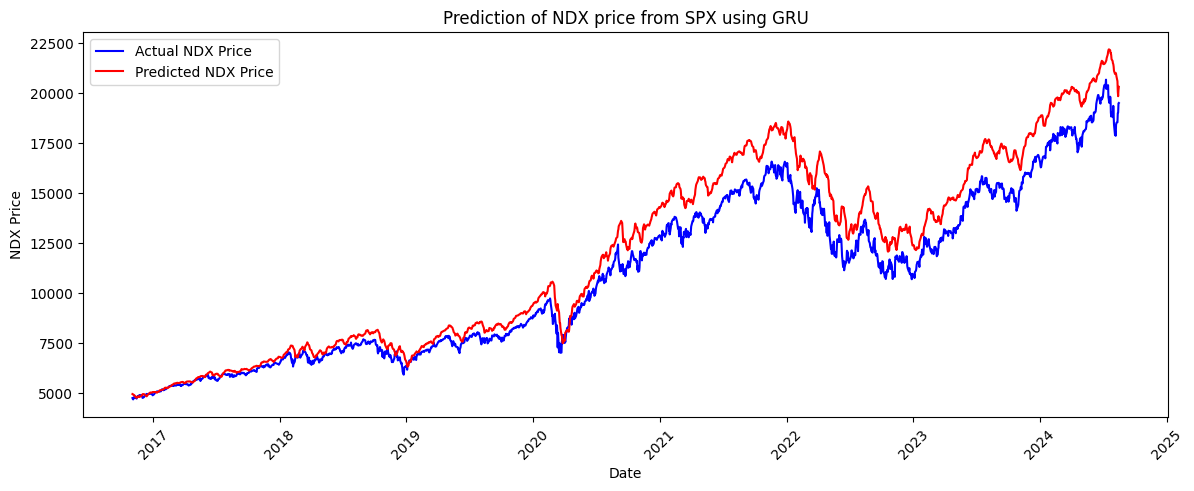

In [10]:
# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_ndx, color='blue', label='Actual NDX Price')
plt.plot(test_dates, predicted_ndx, color='red', label='Predicted NDX Price')
plt.title('Prediction of NDX price from SPX using GRU')
plt.xlabel('Date')
plt.ylabel('NDX Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()


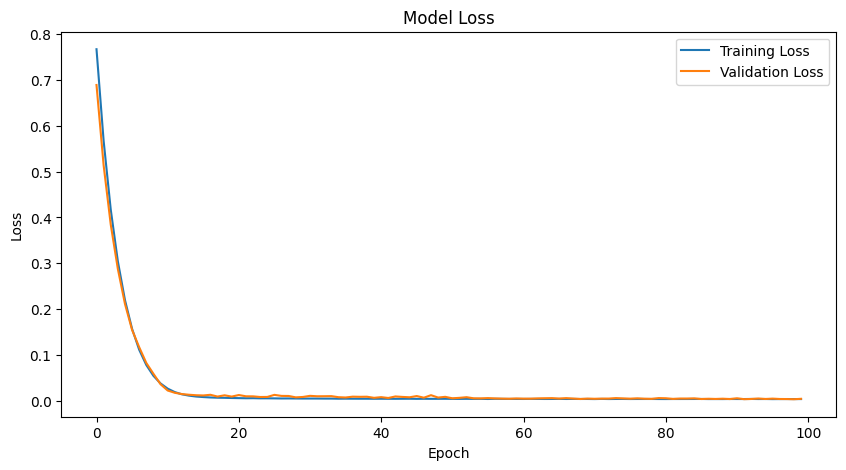

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Prediction of SPX stock prices

# All features

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [13]:
# Load datasets
spx_data = pd.read_csv('spx_daily_85.csv')
ndx_data = pd.read_csv('ndx_daily_85.csv')
dow_data = pd.read_csv('dji_daily_85.csv')

In [14]:
# Convert the Date column to datetime
for df in [ndx_data, spx_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'})
merged_data = merged_data.merge(
    spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))


In [15]:
merged_data.tail()

,Date,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume
9793,2024-08-12,18548.23,18665.75,18433.61,18542.03,9.853609e+08,5351.88,5371.20,5324.37,5344.39,2.285608e+09
9794,2024-08-13,18724.84,19013.02,18723.75,19006.43,1.199671e+09,5376.98,5436.50,5376.98,5434.43,2.602424e+09
9795,2024-08-14,19043.76,19103.00,18837.10,19022.68,1.090248e+09,5442.36,5463.22,5415.91,5455.21,2.352133e+09
9796,2024-08-15,19251.86,19502.92,19239.94,19490.15,1.231034e+09,5501.13,5546.23,5501.13,5543.22,2.676736e+09
9797,2024-08-16,19393.73,19561.24,19376.72,19508.52,1.036048e+09,5530.50,5561.98,5525.17,5554.25,2.288641e+09


In [16]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, 0:6]  # Use all features except SPX variables
        y = data[i+sequence_length, -2]  # Target is SPX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [17]:
# Build the GRU model
model = Sequential()
model.add(GRU(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8596 - val_loss: 0.6721
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6340 - val_loss: 0.4997
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4706 - val_loss: 0.3676
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3468 - val_loss: 0.2681
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2532 - val_loss: 0.1945
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1835 - val_loss: 0.1381
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1326 - val_loss: 0.0979
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0950 - val_loss: 0.0710
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0683 - val_loss: 0.0488
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0493 - val_loss: 0.0356
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0360 - val_loss: 0.0255
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

In [19]:
# Create a placeholder for inverse transformation
predicted_spx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_spx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the SPX_Close column)
predicted_spx_full[:, -2] = predictions[:, 0]
actual_spx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_spx = scaler.inverse_transform(predicted_spx_full)[:, -2]
actual_spx = scaler.inverse_transform(actual_spx_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

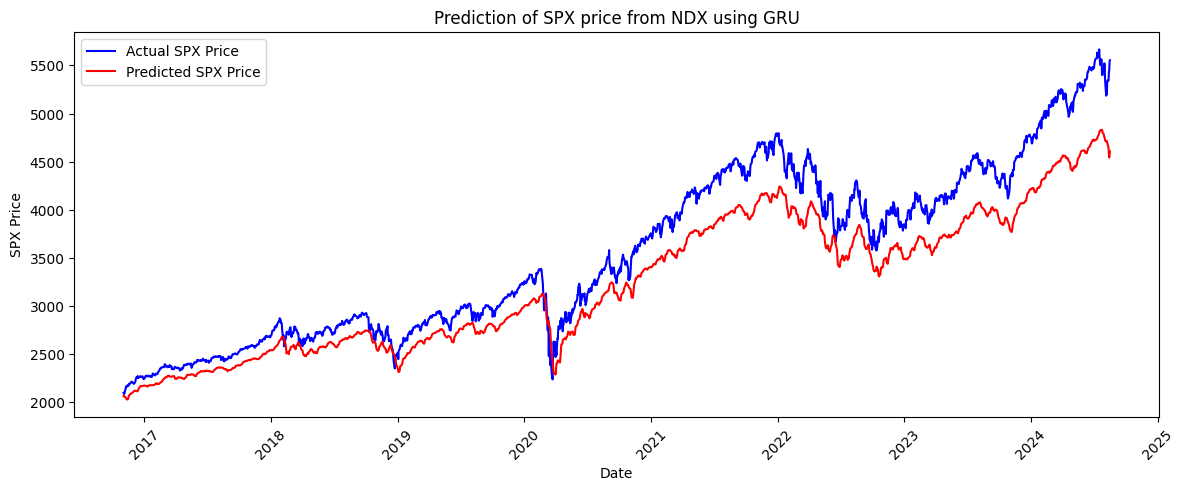

In [20]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_spx, color='blue', label='Actual SPX Price')
plt.plot(test_dates, predicted_spx, color='red', label='Predicted SPX Price')
plt.title('Prediction of SPX price from NDX using GRU')
plt.xlabel('Date')
plt.ylabel('SPX Price')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

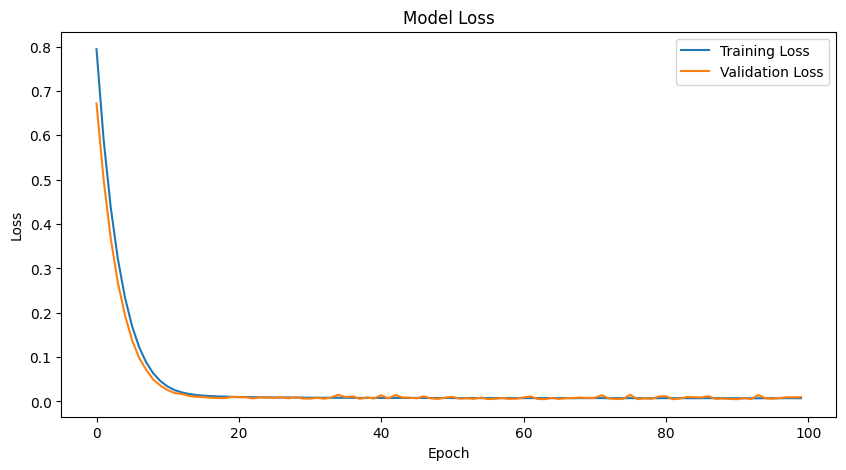

In [21]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# SPX Prediction using DJI and NDX values as features

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [23]:
# Loading the datasets
spx_data = pd.read_csv('spx_daily_85.csv')
ndx_data = pd.read_csv('ndx_daily_85.csv')
dow_data = pd.read_csv('dji_daily_85.csv')

In [24]:
# Convert the Date column to datetime
for df in [ndx_data, spx_data, dow_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = dow_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'DOW_Open', 'High': 'DOW_High', 'Low': 'DOW_Low', 'Close': 'DOW_Close', 'Volume': 'DOW_Volume'})
merged_data = merged_data.merge(
    ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'}), on='Date')
merged_data = merged_data.merge(
    spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))


In [25]:
merged_data.head()

,Date,DOW_Open,DOW_High,DOW_Low,DOW_Close,DOW_Volume,NDX_Open,NDX_High,NDX_Low,NDX_Close,NDX_Volume,SPX_Open,SPX_High,SPX_Low,SPX_Close,SPX_Volume
0,1985-10-01,1328.6,1344.0,1323.5,1341.0,15600373.0,110.62,112.16,110.57,112.14,26406897.0,182.06,185.08,182.02,185.07,72333333.0
1,1985-10-02,1341.0,1351.6,1328.0,1333.7,12576478.0,112.14,112.54,110.78,110.82,28386207.0,185.07,185.94,184.06,184.06,81833333.0
2,1985-10-03,1333.7,1345.4,1323.8,1333.1,10694575.0,110.84,111.18,110.12,110.87,25396552.0,184.06,185.17,183.59,184.36,70833333.0
3,1985-10-04,1333.1,1335.0,1321.1,1328.7,8829276.0,110.87,110.87,109.86,110.07,25500000.0,184.36,184.36,182.65,183.22,56222222.0
4,1985-10-07,1328.7,1335.9,1315.2,1324.4,9299219.0,110.07,110.14,108.18,108.20,22179310.0,183.22,183.22,181.30,181.87,53083333.0


In [26]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except SPX variables
        y = data[i+sequence_length, -2]  # Target is SPX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [27]:
# GRU model
model = Sequential()
model.add(GRU(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.9275 - val_loss: 0.7296
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6867 - val_loss: 0.5474
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5139 - val_loss: 0.4129
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3823 - val_loss: 0.3110
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2823 - val_loss: 0.2310
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2074 - val_loss: 0.1689
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1518 - val_loss: 0.1234
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1107 - val_loss: 0.1005
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0815 - val_loss: 0.0759
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0600 - val_loss: 0.0582
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0450 - val_loss: 0.0528
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

In [29]:
## Create a placeholder for inverse transformation
predicted_spx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_spx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the SPX_Close column)
predicted_spx_full[:, -2] = predictions[:, 0]
actual_spx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_spx = scaler.inverse_transform(predicted_spx_full)[:, -2]
actual_spx = scaler.inverse_transform(actual_spx_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values


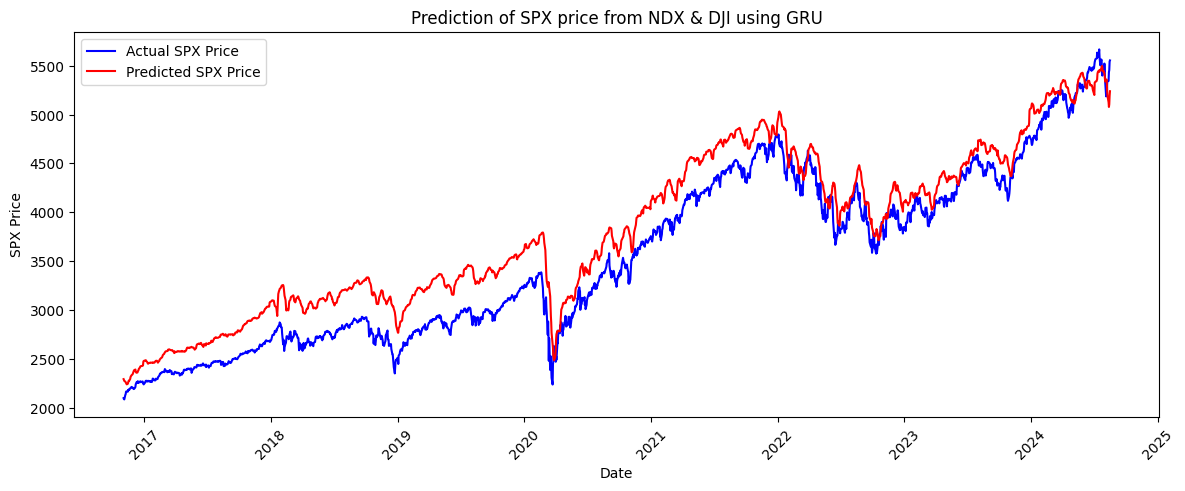

In [30]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_spx, color='blue', label='Actual SPX Price')
plt.plot(test_dates, predicted_spx, color='red', label='Predicted SPX Price')
plt.title('Prediction of SPX price from NDX & DJI using GRU')
plt.xlabel('Date')
plt.ylabel('SPX Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

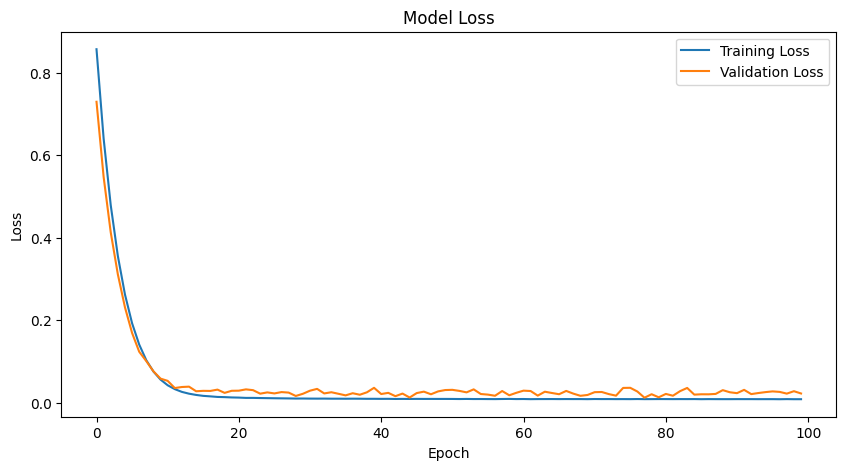

In [31]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## **NDX prediction from DJI & SPX**

In [32]:
# Convert the Date column to datetime
for df in [ndx_data, spx_data, dow_data]:
    df['Date'] = pd.to_datetime(df['Date'])

# Merge the datasets on Date, including all relevant features (Open, High, Low, Close, Volume)
merged_data = dow_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'DOW_Open', 'High': 'DOW_High', 'Low': 'DOW_Low', 'Close': 'DOW_Close', 'Volume': 'DOW_Volume'})
merged_data = merged_data.merge(
    spx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'SPX_Open', 'High': 'SPX_High', 'Low': 'SPX_Low', 'Close': 'SPX_Close', 'Volume': 'SPX_Volume'}), on='Date')
merged_data = merged_data.merge(
    ndx_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'NDX_Open', 'High': 'NDX_High', 'Low': 'NDX_Low', 'Close': 'NDX_Close', 'Volume': 'NDX_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [33]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except NDX variables
        y = data[i+sequence_length, -2]  # Target is NDX_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [34]:
# GRU model
model = Sequential()
model.add(GRU(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(GRU(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.8990 - val_loss: 0.7422
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6716 - val_loss: 0.5697
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5011 - val_loss: 0.4319
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3715 - val_loss: 0.3265
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2738 - val_loss: 0.2461
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2005 - val_loss: 0.1953
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1457 - val_loss: 0.1520
Epoch 8/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1052 - val_loss: 0.1188
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0766 - val_loss: 0.0927
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0556 - val_loss: 0.0799
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0411 - val_loss: 0.0704
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━

In [36]:
## Create a placeholder for inverse transformation
predicted_ndx_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_ndx_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the NDX_Close column)
predicted_ndx_full[:, -2] = predictions[:, 0]
actual_ndx_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted_ndx = scaler.inverse_transform(predicted_ndx_full)[:, -2]
actual_ndx = scaler.inverse_transform(actual_ndx_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

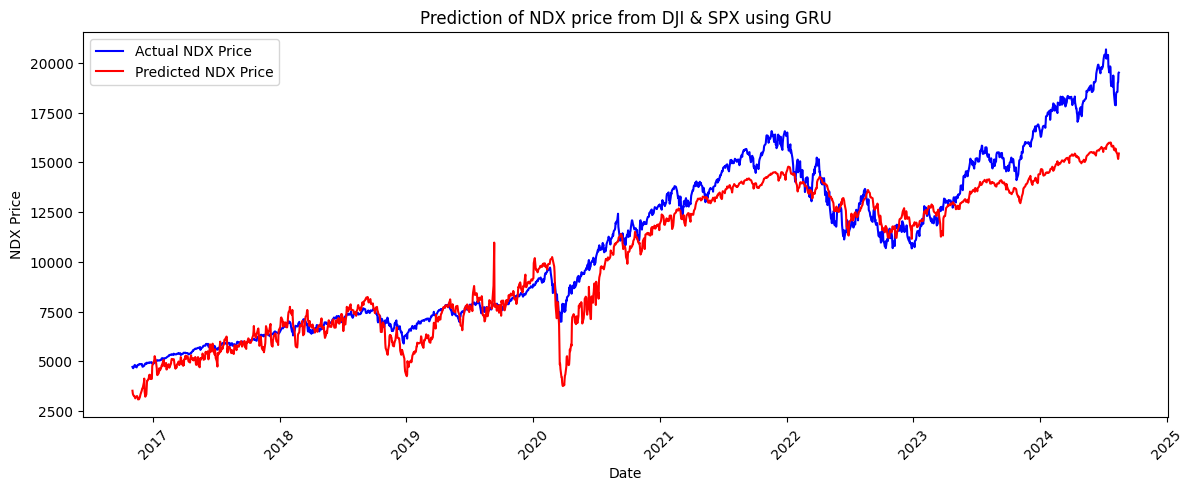

In [37]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_ndx, color='blue', label='Actual NDX Price')
plt.plot(test_dates, predicted_ndx, color='red', label='Predicted NDX Price')
plt.title('Prediction of NDX price from DJI & SPX using GRU')
plt.xlabel('Date')
plt.ylabel('NDX Price')
plt.xticks(rotation=45) 
plt.legend()
plt.show()

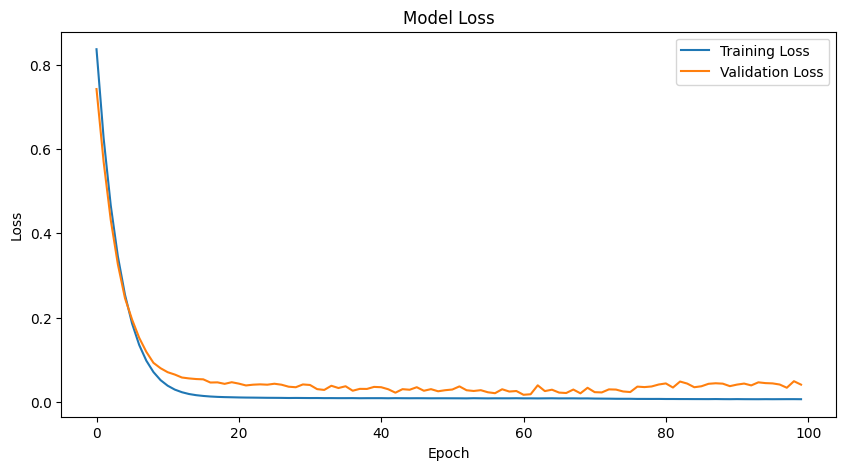

In [38]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()